![](https://raw.githubusercontent.com/GraPharm-ML/grapharm/master/assets/Logo_hori%4033.33x.png)

<a href="https://colab.research.google.com/github/grapharm-ml/grapharm/blob/master/evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" height=27/></a></a> <a href="https://grapharm-ml.github.io/" target="_parent"><img src="https://img.shields.io/badge/github%20pages-121013?style=for-the-badge&logo=github&logoColor=white" alt="Page" height=27/></a>

This notebook will work you through the evaluation of our fine-tuned [ULTRA](https://github.com/DeepGraphLearning/ULTRA) on [Hetinonet](https://het.io/). 
* Evaluate zero-short learning and retrained ULTRA models with 20; 50; and 70 epochs and compare key metrics: `MRR`, `Hits@1`, `Hits@2`, `Hits@10`.
* Showcase some new links unveiling hidden relationships

In [19]:
import warnings
warnings.filterwarnings('ignore')

# Setup for Colab
import sys
from pathlib import Path
IN_COLAB = 'google.colab' in sys.modules

srcpath = Path("grapharm")
on_colab = False

if IN_COLAB and not srcpath.exists(): # if running in Colab --> download src if not exists
    !git clone https://github.com/GraPharm-ML/grapharm
    !mv grapharm/grapharm src
    !pip install pyvis
    on_colab = True
    srcpath = Path("grapharm")
else:
    srcpath = "."

## Evaluation of models

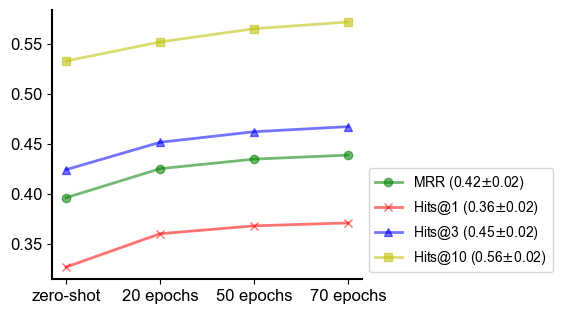

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sys.path.append(srcpath)

import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.linewidth'] = 1.5

df = pd.read_csv(f"{srcpath}/assets/evaluation.csv")
df["epochs"] = df["epochs"].astype(str) + " epochs"
df["epochs"] = df["epochs"].map({"0 epochs": "zero-shot"}).fillna(df["epochs"])
df.set_index("epochs", inplace=True)
markers = ("o", "x", "^", 's')
colors = ('g', 'r', 'b', 'y')
metrics_name = df.columns.to_list()[1:]


plt.figure(figsize=(4,3.5))
ax = plt.subplot()
for i, metric in enumerate(metrics_name):
    ax.plot(
        df[metric],"{}-".format(markers[i]), 
        label=metric + " ({:.2f}".format(np.round(df[metric].mean(),2)) + "$\pm$" + "{:.2f})".format(df[metric].std()), 
        linewidth=2, 
        alpha=0.55,
        color=colors[i],
    )
    
plt.legend(loc='lower left', bbox_to_anchor=(1, 0));
plt.savefig(f"{srcpath}/assets/plots/evaluation_linechart.png", bbox_inches="tight", dpi=400)

## Visualize hidden links

It's more interesting to see some new links are uncovered :)

### Load graph

In [21]:
if on_colab:
    from src._utils import tsv2networkx
    from src.viz import networkx2pyvis, pyvis_opts
else:
    from grapharm._utils import tsv2networkx
    from grapharm.viz import networkx2pyvis, pyvis_opts

datadir = f"{srcpath}/data"

node_df = pd.read_csv(f"{datadir}/hetionet-v1.0-nodes.tsv", sep="\t")
edge_type_df = pd.read_csv(f"{datadir}/metaedges.tsv", sep="\t")
edge_df = pd.read_csv(f"{datadir}/hetionet-v1.0-edges.sif", sep="\t")
new_links = pd.read_csv(f"{datadir}/new_links_v0.csv")

G = tsv2networkx(edge_df, node_df, edge_type_df, new_links)

### Visualize subgraph

In [22]:
import os
from IPython.display import display, IFrame

node_name = "Nonhomologous End-joining (NHEJ)"
node_id = node_df.set_index("name").to_dict()["id"][node_name]

entities = edge_df[(edge_df["source"] == node_id) | 
                   (edge_df["source"] == node_id)] 
nodes = list(set(entities["source"].tolist() + entities["target"].tolist()))
subgraph = G.subgraph(nodes)

# Visualize
options = {
            "notebook": True,
            "height": "750px",
            "width": "100%",
            "cdn_resources": "in_line"
            }
H = networkx2pyvis(subgraph, **options)
H.set_options(pyvis_opts)
os.makedirs(f"{srcpath}/outputs", exist_ok=True)
H.show(f"{srcpath}/outputs/subgraph.html")

display(IFrame(src=f"{srcpath}/outputs/subgraph.html", width=1000, height=750))


./outputs/subgraph.html
